In [1]:
from urllib.request import urlopen
import pandas as pd
import numpy as np
import string
import random
import re
import json
from random import choices

In [ ]:
with open('data_processed2.json', 'r') as f:
    data = json.load(f)

In [ ]:
file_len = len(data)
print('file_len =', file_len)

In [ ]:
all_characters = list(set(data))
n_characters = len(all_characters)
n_characters

In [ ]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

In [ ]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [ ]:
def evaluate(prime_str, predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted.append(predicted_char)
        inp = char_tensor([predicted_char])

    return predicted

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()
    scheduler.step()

    return loss.item() / chunk_len

In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.0001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
scheduler = ExponentialLR(decoder_optimizer, gamma=0.995)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
all_lr = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set()
    loss = train(inp, target)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        # print(evaluate(['n9n9n9n904n9n9n9n9n9n9n9'], 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
    all_lr.append(decoder_optimizer.__dict__['param_groups'][0]['lr'])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure(figsize=(8, 6))
plt.plot(range(0, n_epochs, plot_every), all_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(all_lr)
plt.ylabel('Learning rate')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

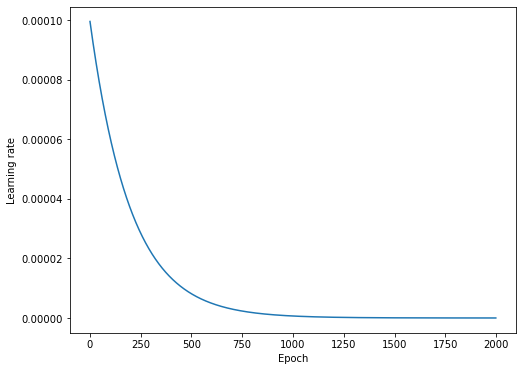

In [68]:
plt.figure(figsize=(8, 6))
plt.plot(all_lr)
plt.ylabel('Learning rate')
plt.xlabel('Epoch')

In [17]:
torch.save(decoder.state_dict(), 'model.pth')

In [18]:
with open('all_characters.json', 'w') as f:
    f.write(json.dumps(all_characters))

In [19]:
with open('params.json', 'w') as f:
    f.write(json.dumps({
        'hidden_size': hidden_size,
        'n_layers': n_layers
    }))